In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import os
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.keras import regularizers

In [2]:
sns.set_style("whitegrid")

In [3]:
dir_gdl = '../data/processed/2016-2019_3std_preprocessed.csv'
df = pd.read_csv(dir_gdl)
df_data = df[df['PARAM']=='PM10'].fillna(-1)
df_data.drop(columns=['Unnamed: 0'], inplace=True)
df_data = df_data[df_data.CEN != -1] #Elimina valores negativos en la columna de salida
df_data

,FECHA,HORA,PARAM,AGU,ATM,CEN,LDO,LPIN,MIR,OBL,SFE,TLA,VAL
4,2016-01-01 00:00:00,00:00,PM10,49.92,146.95,86.12,174.04,-1.0,69.75,197.67,115.54,143.40,17.08
13,2016-01-01 01:00:00,01:00,PM10,52.80,-1.00,46.49,115.27,-1.0,68.99,138.09,84.24,100.46,29.15
22,2016-01-01 02:00:00,02:00,PM10,52.71,113.44,63.93,99.00,-1.0,117.70,98.79,135.39,82.05,30.89
31,2016-01-01 03:00:00,03:00,PM10,51.24,73.30,60.75,83.65,-1.0,160.30,97.94,117.60,114.74,38.74
40,2016-01-01 04:00:00,04:00,PM10,58.84,52.55,108.09,49.70,-1.0,180.89,134.39,164.68,118.83,51.48
...,...,...,...,...,...,...,...,...,...,...,...,...,...
315535,2019-12-31 19:00:00,19:00,PM10,-1.00,18.10,22.27,84.00,46.2,-1.00,-1.00,-1.00,12.68,16.20
315544,2019-12-31 20:00:00,20:00,PM10,-1.00,-1.00,27.51,84.40,57.4,-1.00,-1.00,-1.00,50.31,14.00
315553,2019-12-31 21:00:00,21:00,PM10,-1.00,-1.00,28.60,75.30,151.5,-1.00,-1.00,-1.00,6.86,22.90
315562,2019-12-31 22:00:00,22:00,PM10,-1.00,-1.00,50.43,125.60,174.2,-1.00,-1.00,-1.00,113.16,32.10


In [4]:
X,Y = df_data[['AGU','ATM','LDO','LPIN','MIR','OBL','SFE','TLA','VAL']].to_numpy(), df_data["CEN"].to_numpy()   #separate data into input and output features

Y=np.reshape(Y, (-1,1))

X_std = (X - np.nanmin(np.where(X>=0, X, np.nan),axis=0)) / (X.max(axis=0) - np.nanmin(np.where(X>=0, X, np.nan),axis=0))
xscale = X_std * (1 - 0) + 0
xscale[X==-1]=-1

scaler_y = MinMaxScaler()
scaler_y.fit(Y)
yscale=scaler_y.transform(Y)

X_train,X_test,Y_train,Y_test = train_test_split(X, Y, test_size = 0.2) #split

## Testing code configurations

#### Creating layers

In [5]:
def neuron_layers(nx,nh,ny,hl,act,r, seed=None):
    
    tf.keras.regularizers.l1(l1=r)
    
    initializer = tf.keras.initializers.RandomNormal(seed=seed)
    
    model = Sequential()
    
    for i in range(1, 3+hl):
        
        if i == 1:
            model.add(Dense(nx, input_dim=9, kernel_initializer=initializer,
                            activation=act,kernel_regularizer='l1'))
            
        elif i == (2+hl):
            model.add(Dense(ny, activation='linear'))
            
        else:
            model.add(Dense(nh, activation=act))
            
    return model

## Previous model

In [6]:
nn = pd.read_csv('../output/data/RNA/NN_ModelsNotebook6d_v1.csv')
nn.rename(columns={'Unnamed: 0':'6d_number'}, inplace=True)
print(nn.shape)
nn.head(5)

(200, 20)


,6d_number,6c_model,6b_model,epochs,hidden_neurons,hidden_layers,activation,regularization,random_state_trainsplit,random_WeightInit,acc_train,mse_train,mae_train,rmse_train,ia_train,acc_test,mse_test,mae_test,rmse_test,ia_test
0,model1,model59,model1254,200,100,10,relu,1.0,16,0,0.860960,91.913893,6.459054,9.587173,0.965,0.722726,182.254045,8.366229,13.500150,0.926
1,model2,model59,model1254,200,100,10,relu,1.0,16,2,0.876238,81.814455,5.998837,9.045134,0.966,0.757747,159.234524,7.979057,12.618816,0.931
2,model3,model59,model1254,200,100,10,relu,1.0,16,4,0.874206,83.157717,6.094639,9.119085,0.968,0.745855,167.051276,8.194086,12.924832,0.932
3,model4,model59,model1254,200,100,10,relu,1.0,16,6,0.877532,80.958934,5.998640,8.997718,0.966,0.757323,159.513567,7.863795,12.629868,0.929
4,model5,model59,model1254,200,100,10,relu,1.0,16,8,0.878634,80.230342,5.976462,8.957139,0.966,0.735039,174.160898,8.199043,13.197003,0.921


In [7]:
df_bestmodels = pd.read_csv('../output/data/RNA/BestModels_Notebook6d.csv')
print(df_bestmodels.shape)
df_bestmodels.head(4)

(10, 6)


,Unnamed: 0,model,6b_model,6c_model,variable,result
0,0,model9,model1254,model59,mse_train,71.800892
1,1,model9,model1254,model59,mae_train,5.612536
2,2,model9,model1254,model59,rmse_train,8.473541
3,3,model130,model732,model111,mse_test,125.692934


In [8]:
df_bestmodels.model.unique()

array(['model9', 'model130', 'model187', 'model74'], dtype=object)

## Applying model for all stations

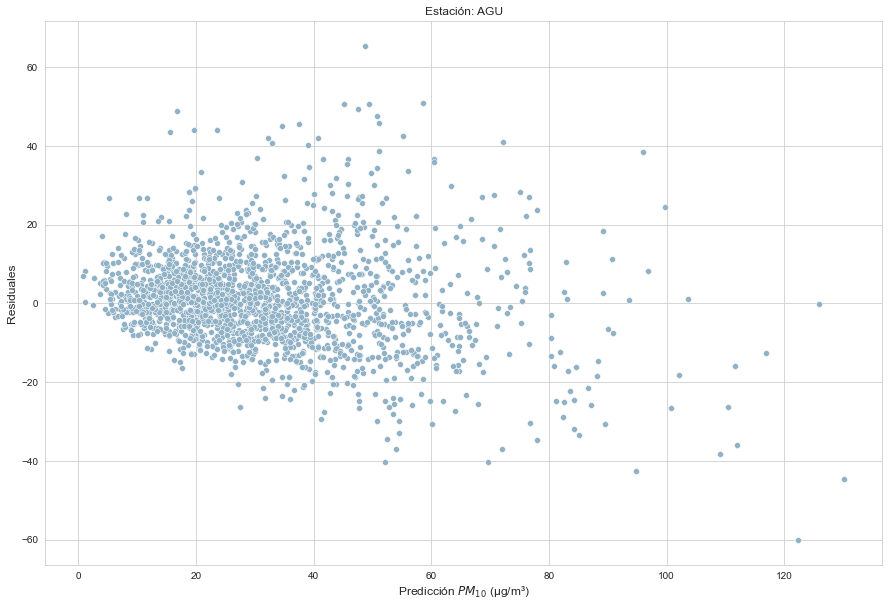


*For model model9 settings are: -epochs: 200 -hidden neurons: 100 -hidden layers: 10 -activation: relu -regularization cost: 1.0 -traintest: 16 -randomWeightInit 16 -station: AGU 
Accuracy for training is: 0.8393298931714774 Accuracy for test is: 0.6342565270582894 
MSE for training is: 64.50574813284031 MSE for test is: 140.9349272264217 
MAE for training is: 5.346894168317494 MAE for test is: 8.54205794073526 
RMSE for training is: 8.031547057251194 RMSE for test is: 11.871601712760654 
IA for training is: 0.954 IA for test is: 0.892


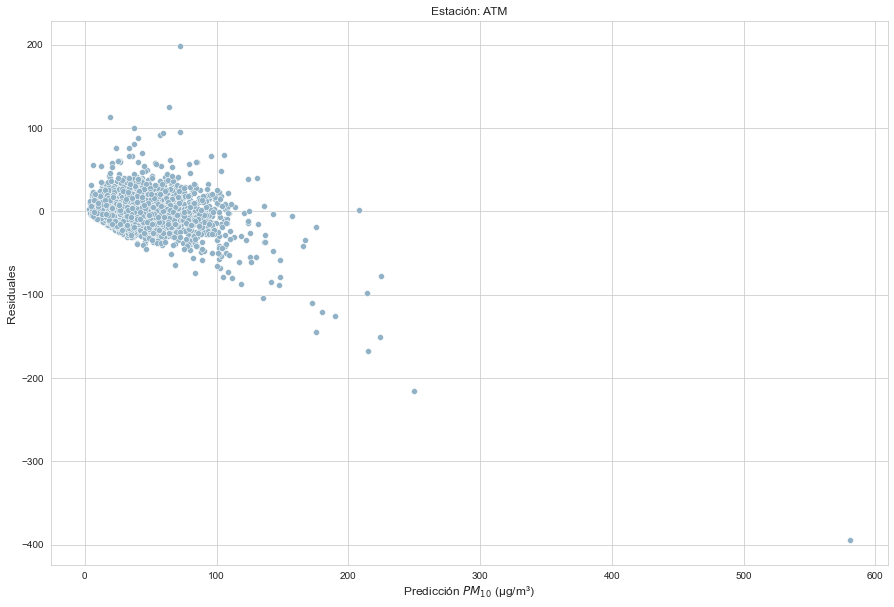


*For model model9 settings are: -epochs: 200 -hidden neurons: 100 -hidden layers: 10 -activation: relu -regularization cost: 1.0 -traintest: 16 -randomWeightInit 16 -station: ATM 
Accuracy for training is: 0.7394775110428486 Accuracy for test is: 0.4597679274397164 
MSE for training is: 152.476078827471 MSE for test is: 306.9076206374491 
MAE for training is: 8.142887745085618 MAE for test is: 10.7231183110776 
RMSE for training is: 12.348120457278954 RMSE for test is: 17.51877908524019 
IA for training is: 0.925 IA for test is: 0.849


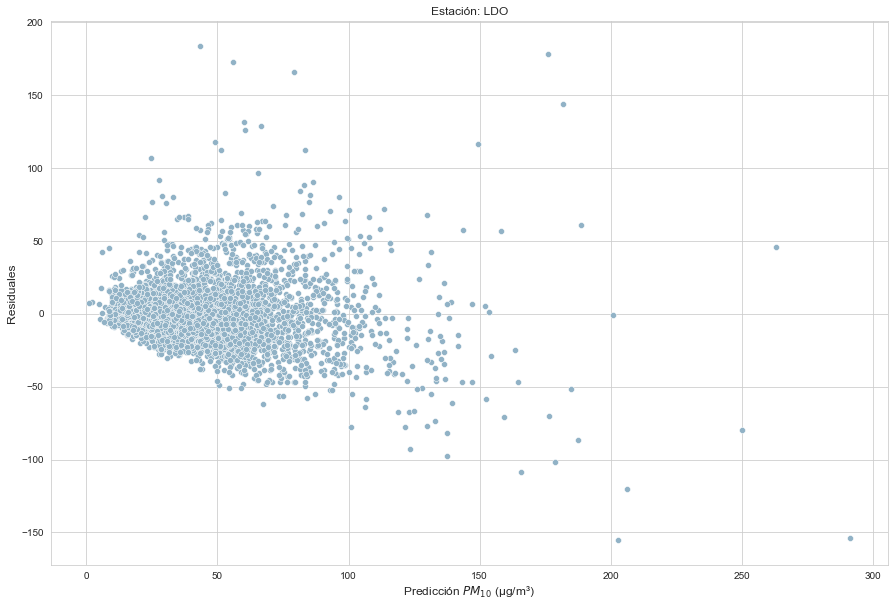


*For model model9 settings are: -epochs: 200 -hidden neurons: 100 -hidden layers: 10 -activation: relu -regularization cost: 1.0 -traintest: 16 -randomWeightInit 16 -station: LDO 
Accuracy for training is: 0.7343462346735652 Accuracy for test is: 0.5412404967880753 
MSE for training is: 222.99224328230295 MSE for test is: 401.4564014226275 
MAE for training is: 10.254480981739984 MAE for test is: 13.425753349038578 
RMSE for training is: 14.932924806691519 RMSE for test is: 20.036376953497044 
IA for training is: 0.919 IA for test is: 0.847


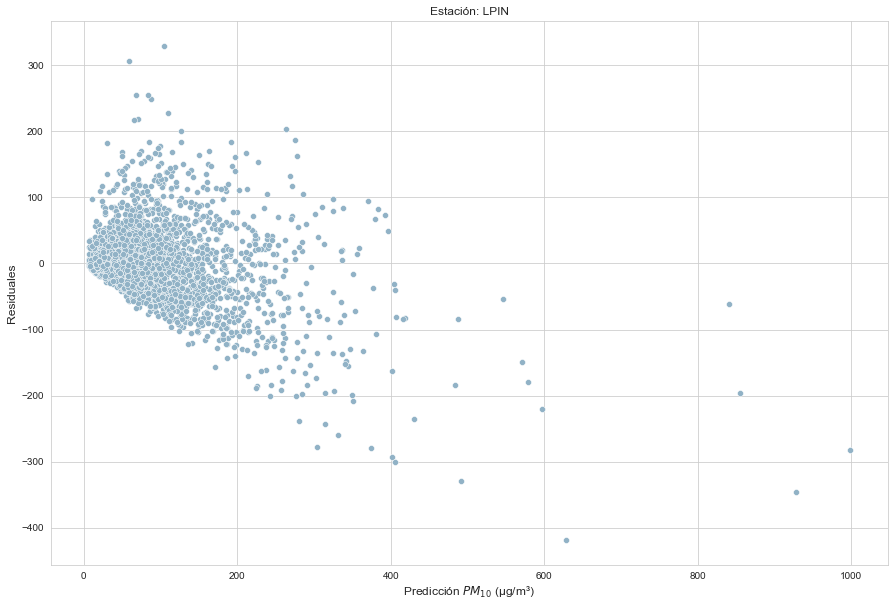


*For model model9 settings are: -epochs: 200 -hidden neurons: 100 -hidden layers: 10 -activation: relu -regularization cost: 1.0 -traintest: 16 -randomWeightInit 16 -station: LPIN 
Accuracy for training is: 0.7646484361017105 Accuracy for test is: 0.5669004492603797 
MSE for training is: 973.794331036484 MSE for test is: 1795.7505781858704 
MAE for training is: 19.20176206312685 MAE for test is: 25.84534438980133 
RMSE for training is: 31.205677865357835 RMSE for test is: 42.37629736286395 
IA for training is: 0.936 IA for test is: 0.881


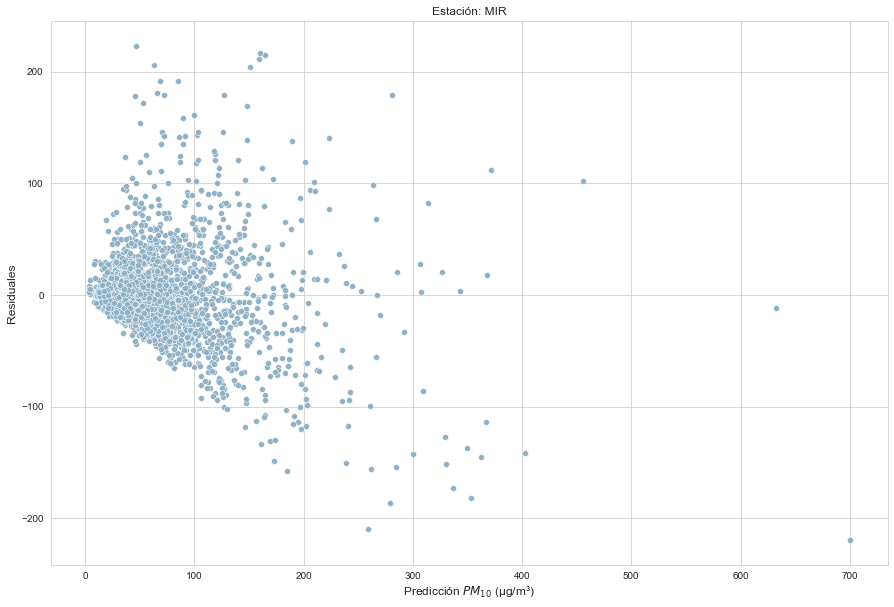


*For model model9 settings are: -epochs: 200 -hidden neurons: 100 -hidden layers: 10 -activation: relu -regularization cost: 1.0 -traintest: 16 -randomWeightInit 16 -station: MIR 
Accuracy for training is: 0.772307174160021 Accuracy for test is: 0.5876046337346575 
MSE for training is: 604.9213809071852 MSE for test is: 1179.3087474886772 
MAE for training is: 15.346329701912573 MAE for test is: 21.241104024321846 
RMSE for training is: 24.59514954024848 RMSE for test is: 34.34106503136845 
IA for training is: 0.934 IA for test is: 0.873


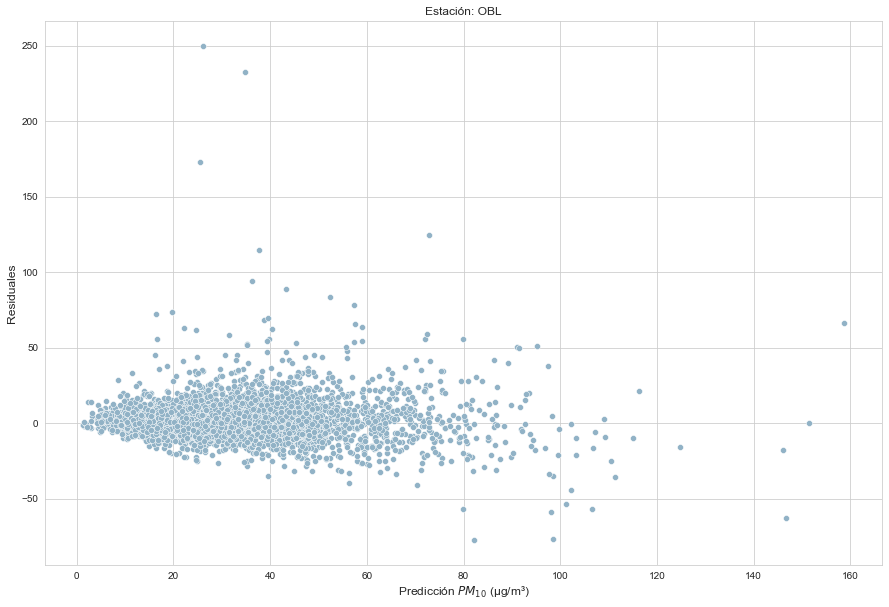


*For model model9 settings are: -epochs: 200 -hidden neurons: 100 -hidden layers: 10 -activation: relu -regularization cost: 1.0 -traintest: 16 -randomWeightInit 16 -station: OBL 
Accuracy for training is: 0.8032287093161627 Accuracy for test is: 0.6198362010369487 
MSE for training is: 84.96365262089783 MSE for test is: 177.67334116128723 
MAE for training is: 6.134734130859999 MAE for test is: 8.120406663898398 
RMSE for training is: 9.217573033119827 RMSE for test is: 13.32941638487174 
IA for training is: 0.941 IA for test is: 0.873


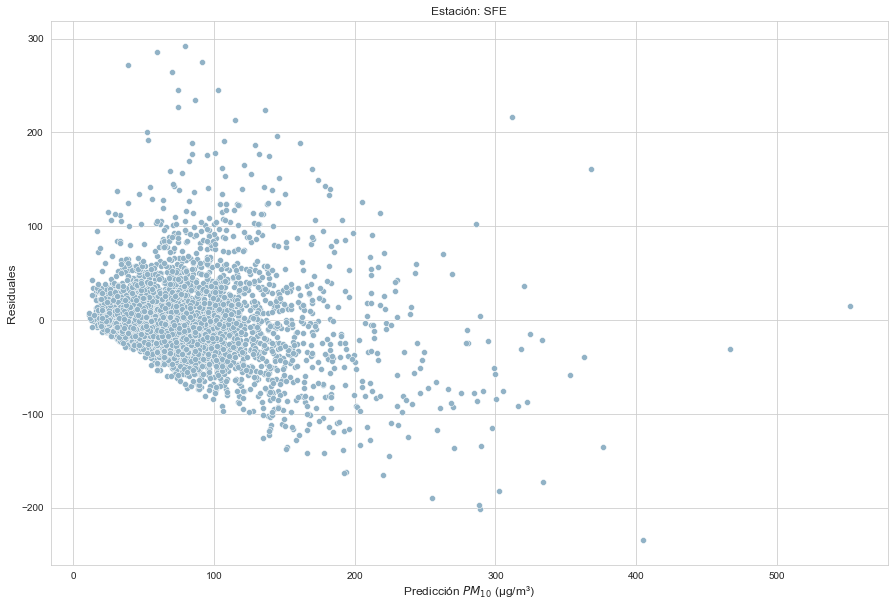


*For model model9 settings are: -epochs: 200 -hidden neurons: 100 -hidden layers: 10 -activation: relu -regularization cost: 1.0 -traintest: 16 -randomWeightInit 16 -station: SFE 
Accuracy for training is: 0.7403909523291875 Accuracy for test is: 0.4580968837381889 
MSE for training is: 779.4575706075034 MSE for test is: 1671.5759210300082 
MAE for training is: 17.752176771856146 MAE for test is: 26.893133979585905 
RMSE for training is: 27.918767354729386 RMSE for test is: 40.88491067655656 
IA for training is: 0.922 IA for test is: 0.82


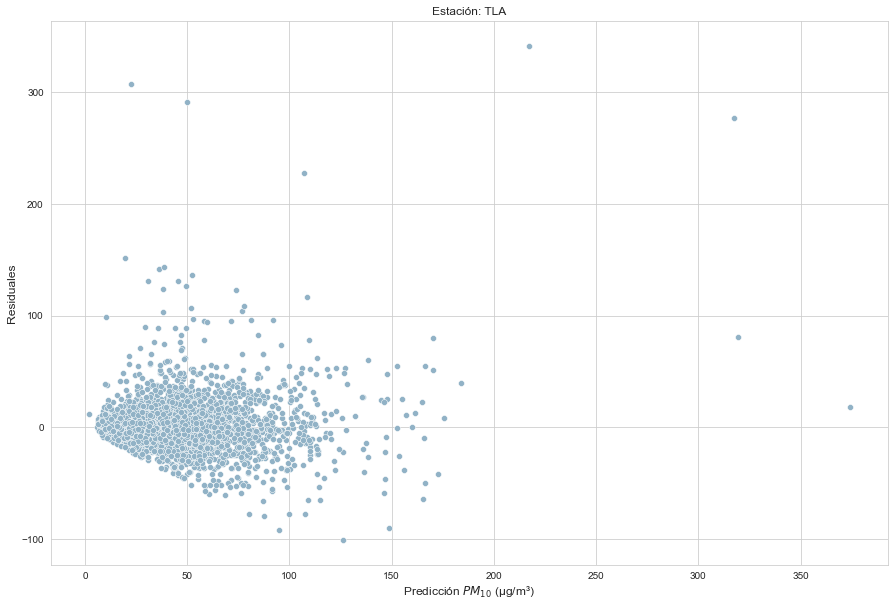


*For model model9 settings are: -epochs: 200 -hidden neurons: 100 -hidden layers: 10 -activation: relu -regularization cost: 1.0 -traintest: 16 -randomWeightInit 16 -station: TLA 
Accuracy for training is: 0.7260163095547688 Accuracy for test is: 0.6185060803178979 
MSE for training is: 264.383829983875 MSE for test is: 400.18454989889426 
MAE for training is: 10.345015792819977 MAE for test is: 11.58508045370451 
RMSE for training is: 16.25988407043159 RMSE for test is: 20.004613215428442 
IA for training is: 0.913 IA for test is: 0.864


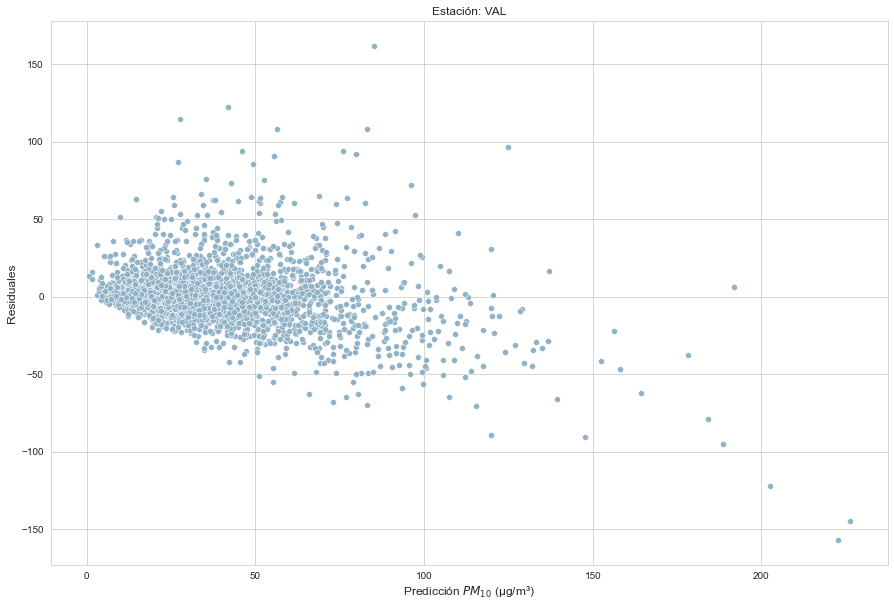


*For model model9 settings are: -epochs: 200 -hidden neurons: 100 -hidden layers: 10 -activation: relu -regularization cost: 1.0 -traintest: 16 -randomWeightInit 16 -station: VAL 
Accuracy for training is: 0.7886491603986812 Accuracy for test is: 0.500750328401635 
MSE for training is: 127.80909502785273 MSE for test is: 298.3619732503835 
MAE for training is: 7.2474655253297176 MAE for test is: 10.97412095312459 
RMSE for training is: 11.305268463325085 RMSE for test is: 17.27315759351438 
IA for training is: 0.943 IA for test is: 0.849


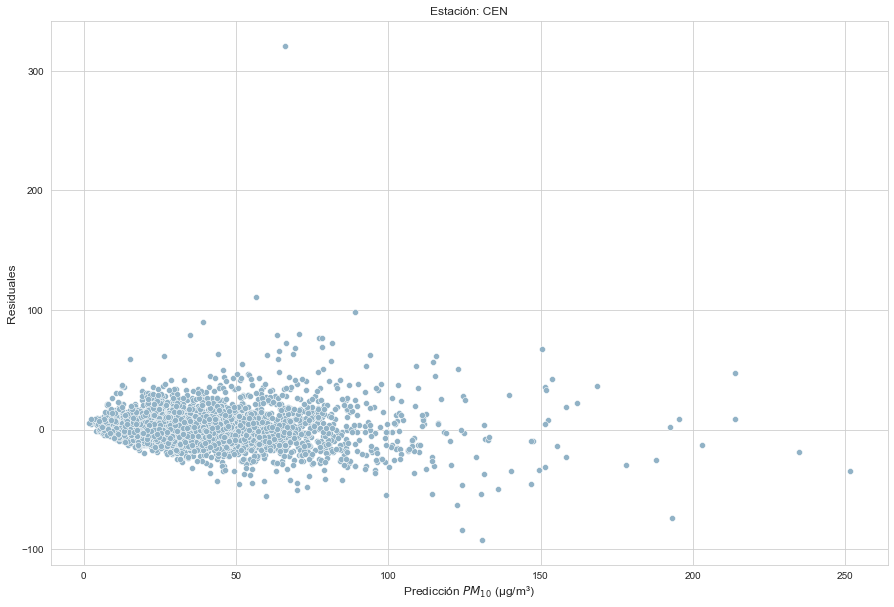


*For model model9 settings are: -epochs: 200 -hidden neurons: 100 -hidden layers: 10 -activation: relu -regularization cost: 1.0 -traintest: 16 -randomWeightInit 16 -station: CEN 
Accuracy for training is: 0.8850668022270658 Accuracy for test is: 0.7471374119761895 
MSE for training is: 75.9779750361599 MSE for test is: 166.2083394621765 
MAE for training is: 5.809106764935453 MAE for test is: 8.041058663664504 
RMSE for training is: 8.716534577236525 RMSE for test is: 12.892181330642867 
IA for training is: 0.968 IA for test is: 0.924


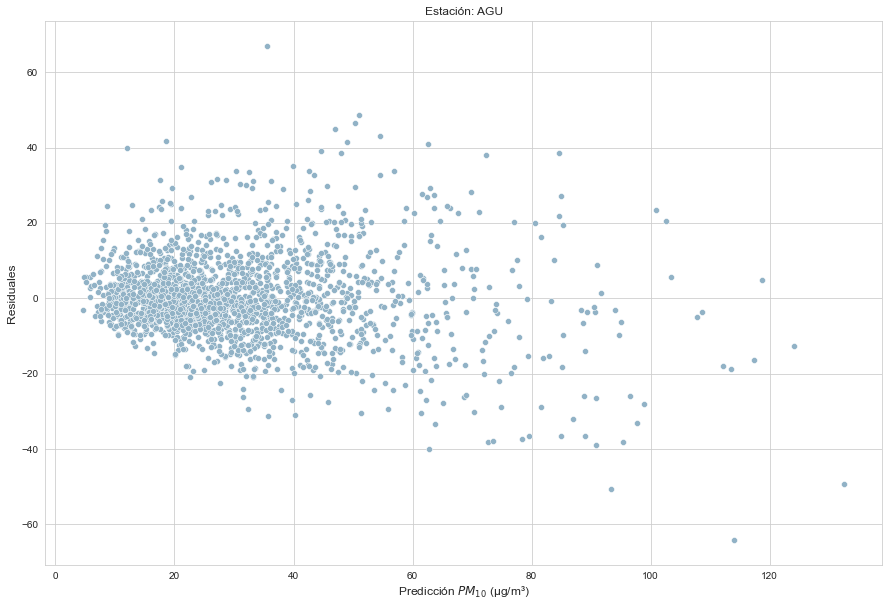


*For model model130 settings are: -epochs: 100 -hidden neurons: 75 -hidden layers: 5 -activation: relu -regularization cost: 0.1 -traintest: 20 -randomWeightInit 58 -station: AGU 
Accuracy for training is: 0.7948771600145148 Accuracy for test is: 0.6758329570940059 
MSE for training is: 82.11181291617929 MSE for test is: 126.23348271770702 
MAE for training is: 6.517274465284953 MAE for test is: 7.9912457140835125 
RMSE for training is: 9.061556870437844 RMSE for test is: 11.235367493665128 
IA for training is: 0.941 IA for test is: 0.904


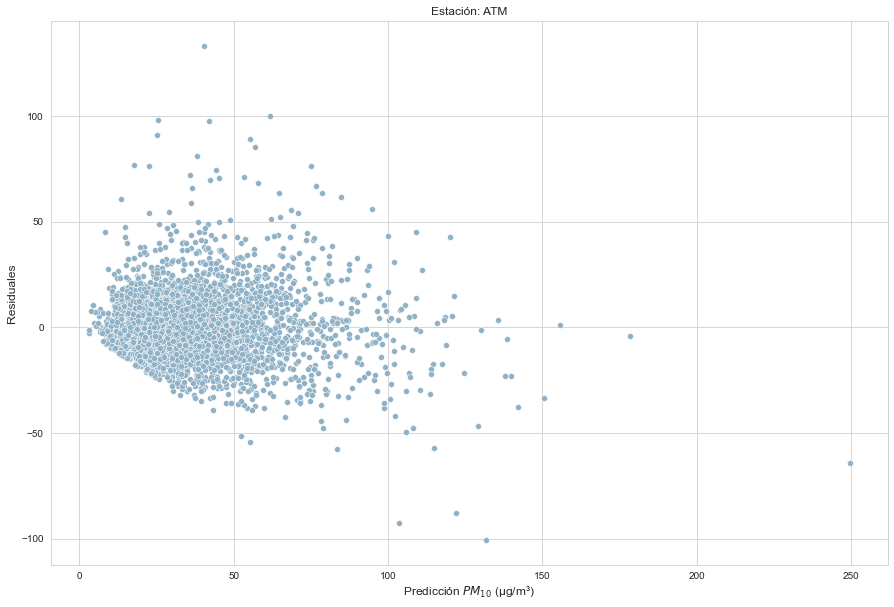


*For model model130 settings are: -epochs: 100 -hidden neurons: 75 -hidden layers: 5 -activation: relu -regularization cost: 0.1 -traintest: 20 -randomWeightInit 58 -station: ATM 
Accuracy for training is: 0.6591511450040677 Accuracy for test is: 0.6224576369302656 
MSE for training is: 201.01445310838304 MSE for test is: 207.80628790964175 
MAE for training is: 9.38898138907685 MAE for test is: 9.996388061022893 
RMSE for training is: 14.177956591426813 RMSE for test is: 14.415487779109029 
IA for training is: 0.886 IA for test is: 0.876


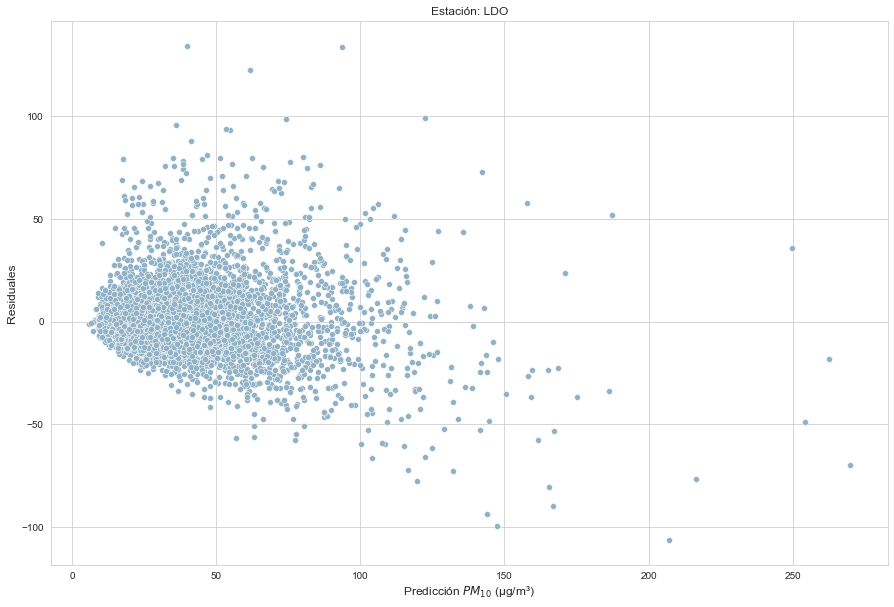


*For model model130 settings are: -epochs: 100 -hidden neurons: 75 -hidden layers: 5 -activation: relu -regularization cost: 0.1 -traintest: 20 -randomWeightInit 58 -station: LDO 
Accuracy for training is: 0.6708974930585745 Accuracy for test is: 0.6010966868251731 
MSE for training is: 281.66025206630576 MSE for test is: 322.85555144211764 
MAE for training is: 11.481087879394657 MAE for test is: 12.292060704342786 
RMSE for training is: 16.78273672755149 RMSE for test is: 17.96818163983539 
IA for training is: 0.894 IA for test is: 0.875


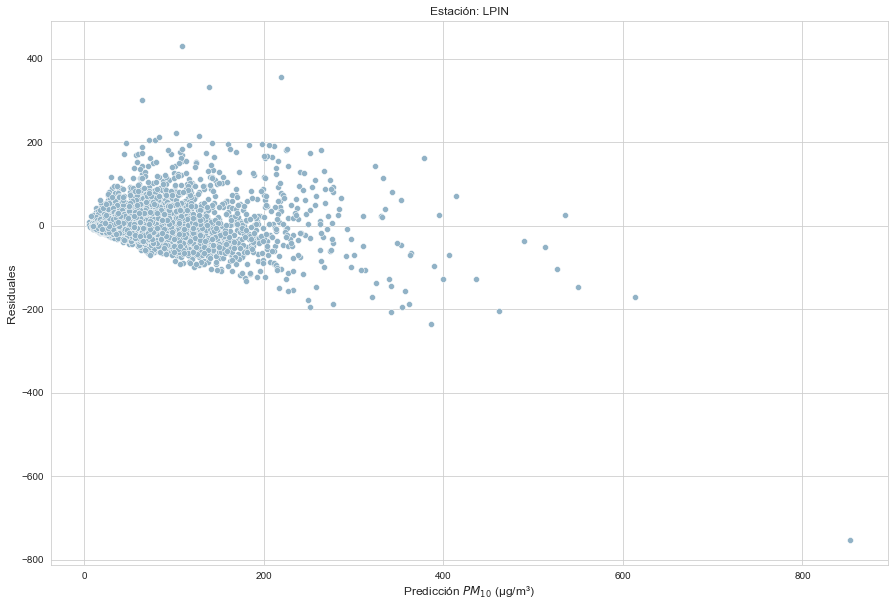


*For model model130 settings are: -epochs: 100 -hidden neurons: 75 -hidden layers: 5 -activation: relu -regularization cost: 0.1 -traintest: 20 -randomWeightInit 58 -station: LPIN 
Accuracy for training is: 0.7080294162159098 Accuracy for test is: 0.6196674922363669 
MSE for training is: 1217.4275788831062 MSE for test is: 1528.1393067849028 
MAE for training is: 21.996188220080118 MAE for test is: 23.341545418164856 
RMSE for training is: 34.89165486019696 RMSE for test is: 39.09142241956543 
IA for training is: 0.913 IA for test is: 0.88


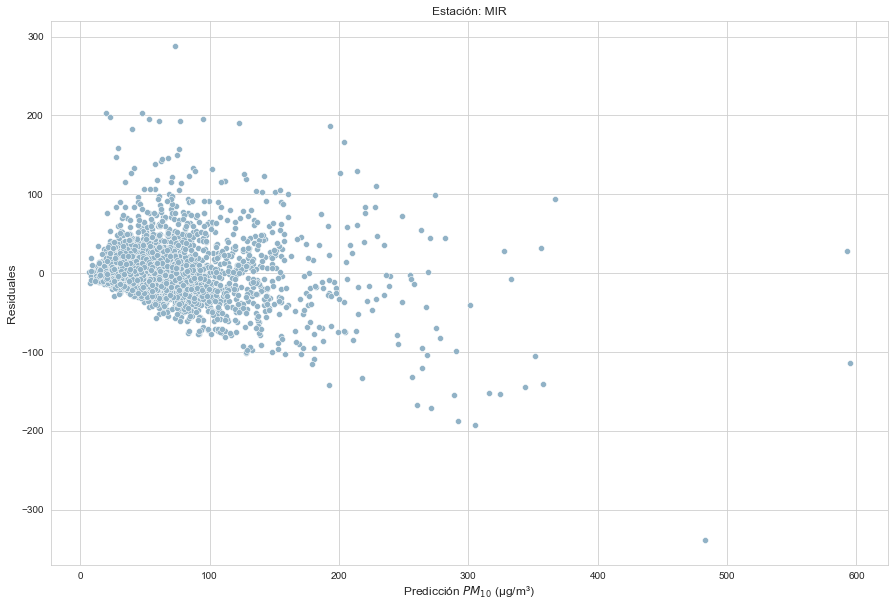


*For model model130 settings are: -epochs: 100 -hidden neurons: 75 -hidden layers: 5 -activation: relu -regularization cost: 0.1 -traintest: 20 -randomWeightInit 58 -station: MIR 
Accuracy for training is: 0.6944600950080793 Accuracy for test is: 0.5778107732462961 
MSE for training is: 828.9909403083196 MSE for test is: 1111.755943474175 
MAE for training is: 18.299532497266945 MAE for test is: 20.5502327812602 
RMSE for training is: 28.792202769297102 RMSE for test is: 33.34300441583174 
IA for training is: 0.904 IA for test is: 0.87


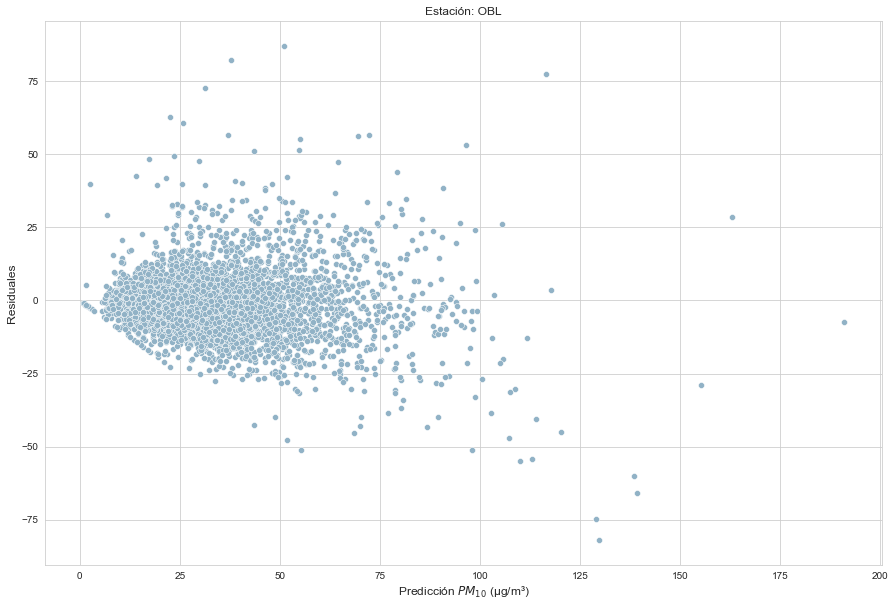


*For model model130 settings are: -epochs: 100 -hidden neurons: 75 -hidden layers: 5 -activation: relu -regularization cost: 0.1 -traintest: 20 -randomWeightInit 58 -station: OBL 
Accuracy for training is: 0.7466169605654593 Accuracy for test is: 0.7051416686853517 
MSE for training is: 112.9137274259656 MSE for test is: 121.40338901369621 
MAE for training is: 7.183164022379536 MAE for test is: 7.5793673240514305 
RMSE for training is: 10.62608711737136 RMSE for test is: 11.018320607683197 
IA for training is: 0.925 IA for test is: 0.912


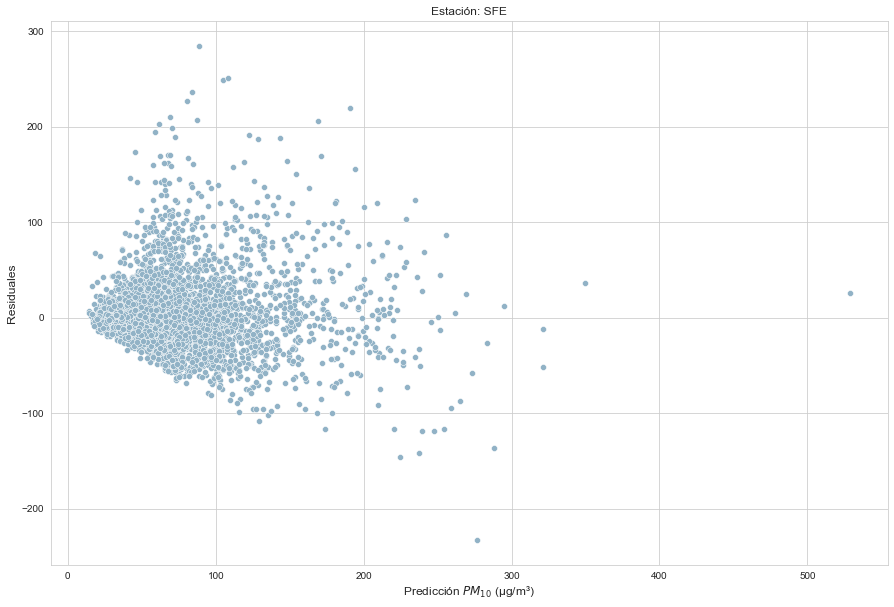


*For model model130 settings are: -epochs: 100 -hidden neurons: 75 -hidden layers: 5 -activation: relu -regularization cost: 0.1 -traintest: 20 -randomWeightInit 58 -station: SFE 
Accuracy for training is: 0.6188688629063946 Accuracy for test is: 0.5385929873439808 
MSE for training is: 1158.9297311548753 MSE for test is: 1352.378192615311 
MAE for training is: 22.258103041829965 MAE for test is: 23.9818579757172 
RMSE for training is: 34.043057018353615 RMSE for test is: 36.774695003702085 
IA for training is: 0.865 IA for test is: 0.833


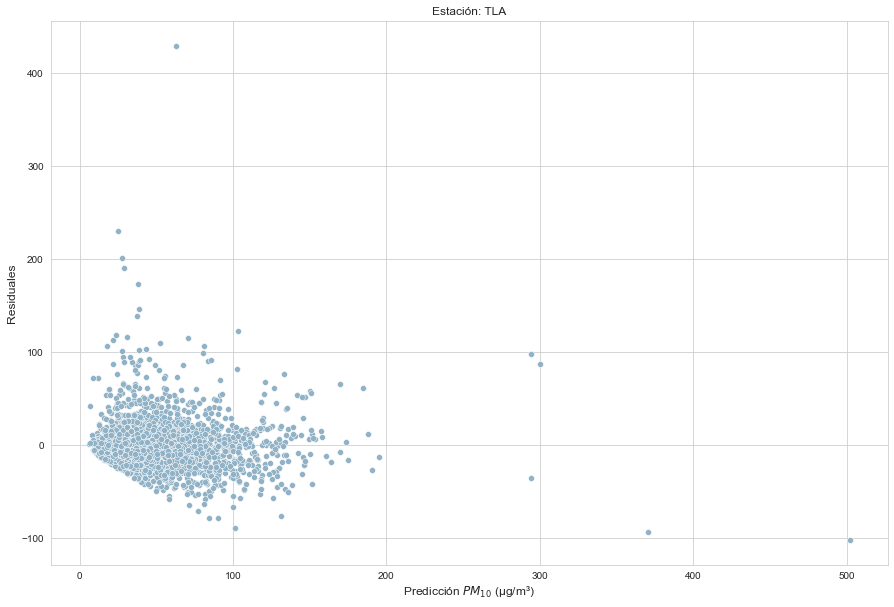


*For model model130 settings are: -epochs: 100 -hidden neurons: 75 -hidden layers: 5 -activation: relu -regularization cost: 0.1 -traintest: 20 -randomWeightInit 58 -station: TLA 
Accuracy for training is: 0.7044610610624744 Accuracy for test is: 0.6226743109480226 
MSE for training is: 287.2947474241561 MSE for test is: 384.96255187139656 
MAE for training is: 10.555474559138636 MAE for test is: 11.70531210310468 
RMSE for training is: 16.94977130890432 RMSE for test is: 19.620462580464217 
IA for training is: 0.908 IA for test is: 0.879


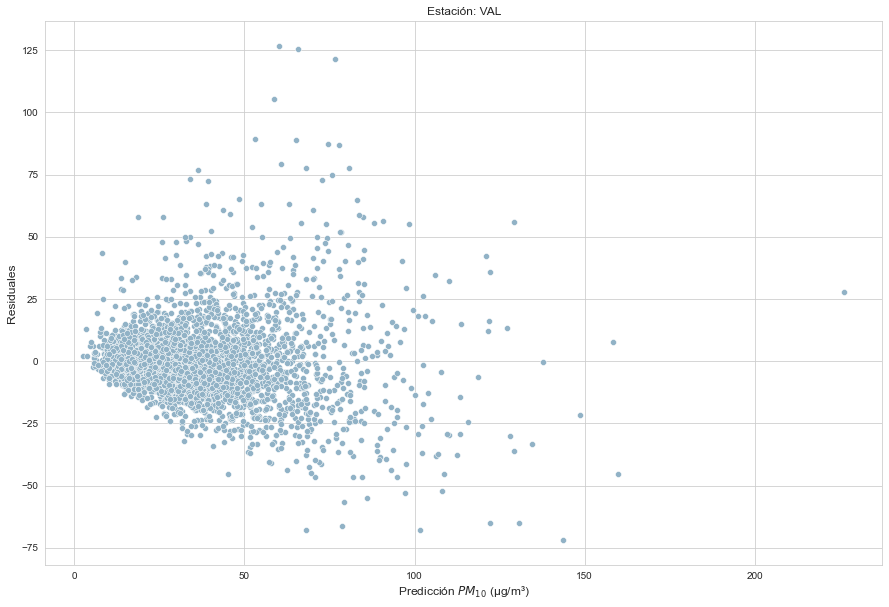


*For model model130 settings are: -epochs: 100 -hidden neurons: 75 -hidden layers: 5 -activation: relu -regularization cost: 0.1 -traintest: 20 -randomWeightInit 58 -station: VAL 
Accuracy for training is: 0.6876096903363098 Accuracy for test is: 0.6047685834459362 
MSE for training is: 187.57781011696918 MSE for test is: 242.9721214154291 
MAE for training is: 9.208990348439027 MAE for test is: 10.412588780833653 
RMSE for training is: 13.695904866673438 RMSE for test is: 15.587563036454066 
IA for training is: 0.901 IA for test is: 0.869


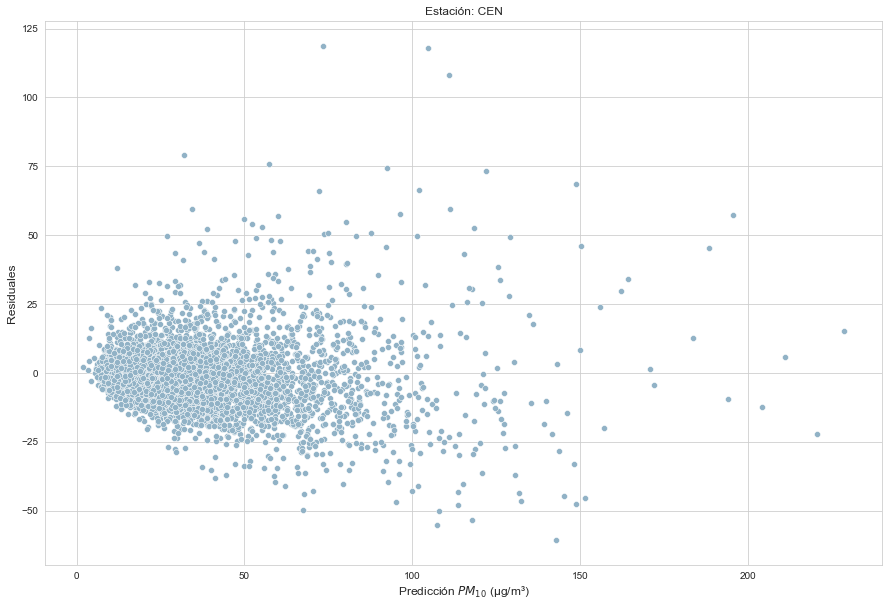


*For model model130 settings are: -epochs: 100 -hidden neurons: 75 -hidden layers: 5 -activation: relu -regularization cost: 0.1 -traintest: 20 -randomWeightInit 58 -station: CEN 
Accuracy for training is: 0.8268773300404433 Accuracy for test is: 0.7934449566993326 
MSE for training is: 115.3685727631215 MSE for test is: 131.27742868510094 
MAE for training is: 7.322154464226183 MAE for test is: 7.714915798471052 
RMSE for training is: 10.740976341242053 RMSE for test is: 11.457636260813176 
IA for training is: 0.951 IA for test is: 0.941


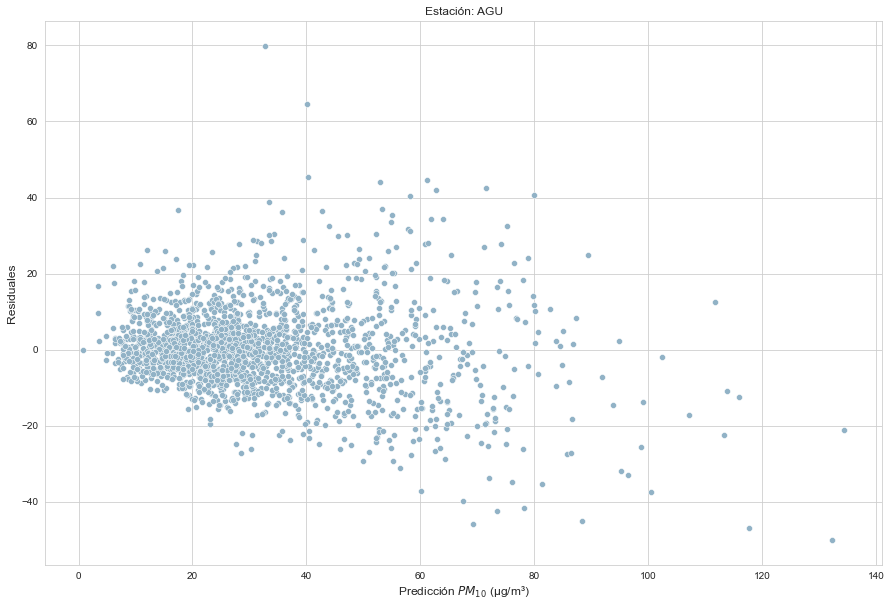


*For model model187 settings are: -epochs: 100 -hidden neurons: 75 -hidden layers: 5 -activation: relu -regularization cost: 0.1 -traintest: 96 -randomWeightInit 72 -station: AGU 
Accuracy for training is: 0.7661486545996203 Accuracy for test is: 0.6870195093431946 
MSE for training is: 93.51934792157626 MSE for test is: 122.58639768258607 
MAE for training is: 6.8895073435422285 MAE for test is: 7.89773010552973 
RMSE for training is: 9.670540208363557 RMSE for test is: 11.07187417208966 
IA for training is: 0.934 IA for test is: 0.909


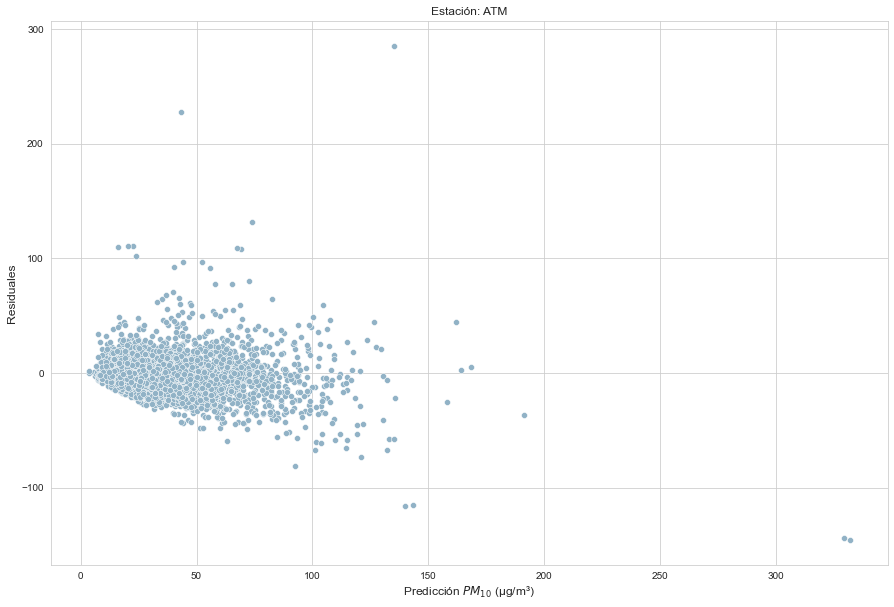


*For model model187 settings are: -epochs: 100 -hidden neurons: 75 -hidden layers: 5 -activation: relu -regularization cost: 0.1 -traintest: 96 -randomWeightInit 72 -station: ATM 
Accuracy for training is: 0.6730750831614594 Accuracy for test is: 0.5633136685443743 
MSE for training is: 187.3391682563957 MSE for test is: 269.54541210660767 
MAE for training is: 9.310487784180019 MAE for test is: 10.498234971111591 
RMSE for training is: 13.687189932794668 RMSE for test is: 16.41783822878663 
IA for training is: 0.902 IA for test is: 0.863


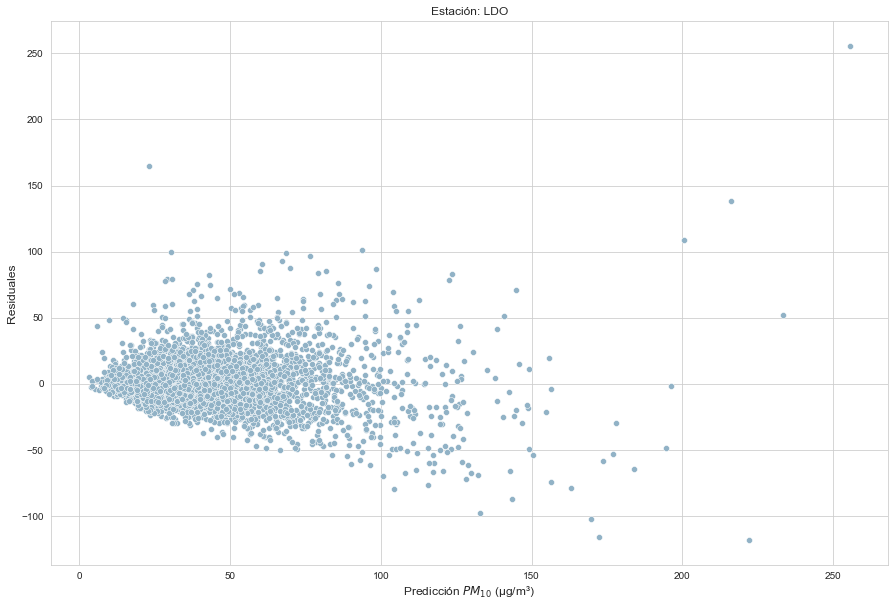


*For model model187 settings are: -epochs: 100 -hidden neurons: 75 -hidden layers: 5 -activation: relu -regularization cost: 0.1 -traintest: 96 -randomWeightInit 72 -station: LDO 
Accuracy for training is: 0.6911440987633417 Accuracy for test is: 0.5994230808104246 
MSE for training is: 259.7726086575674 MSE for test is: 347.8594934629131 
MAE for training is: 11.19680575320096 MAE for test is: 12.496671279242351 
RMSE for training is: 16.11746284802814 RMSE for test is: 18.650991755478127 
IA for training is: 0.904 IA for test is: 0.869


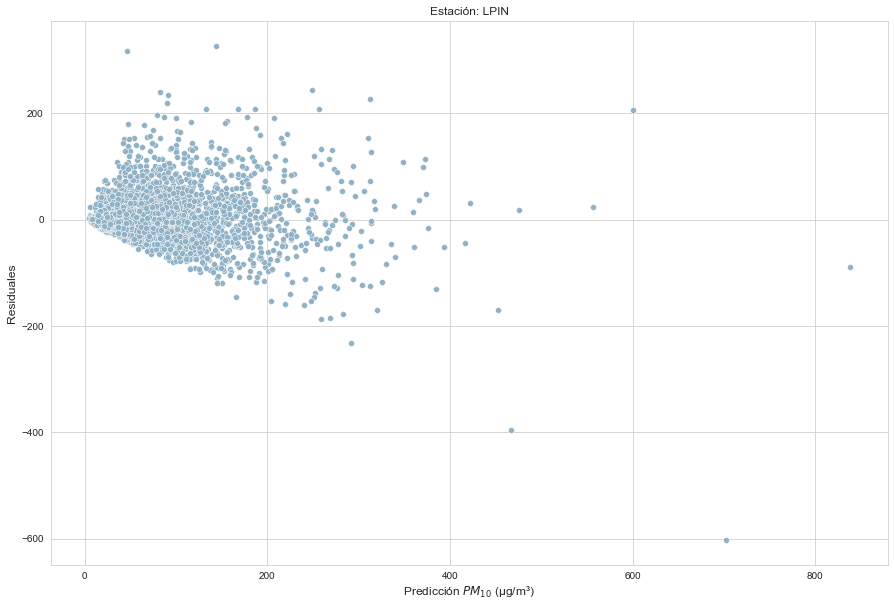


*For model model187 settings are: -epochs: 100 -hidden neurons: 75 -hidden layers: 5 -activation: relu -regularization cost: 0.1 -traintest: 96 -randomWeightInit 72 -station: LPIN 
Accuracy for training is: 0.715754245527188 Accuracy for test is: 0.654000280500886 
MSE for training is: 1175.2361513140622 MSE for test is: 1438.9254628063168 
MAE for training is: 21.752189804588706 MAE for test is: 23.244874526088378 
RMSE for training is: 34.281717449889555 RMSE for test is: 37.933171009109124 
IA for training is: 0.913 IA for test is: 0.891


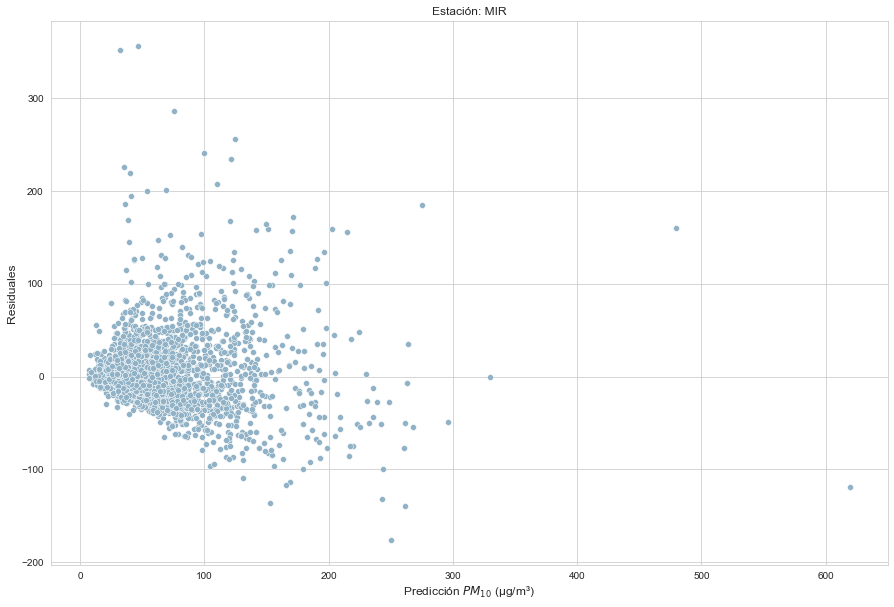


*For model model187 settings are: -epochs: 100 -hidden neurons: 75 -hidden layers: 5 -activation: relu -regularization cost: 0.1 -traintest: 96 -randomWeightInit 72 -station: MIR 
Accuracy for training is: 0.7153924865485171 Accuracy for test is: 0.572201103491905 
MSE for training is: 768.2521784803596 MSE for test is: 1150.307239462018 
MAE for training is: 17.411039164090933 MAE for test is: 20.22829520096404 
RMSE for training is: 27.71736240121631 RMSE for test is: 33.91617961183155 
IA for training is: 0.906 IA for test is: 0.849


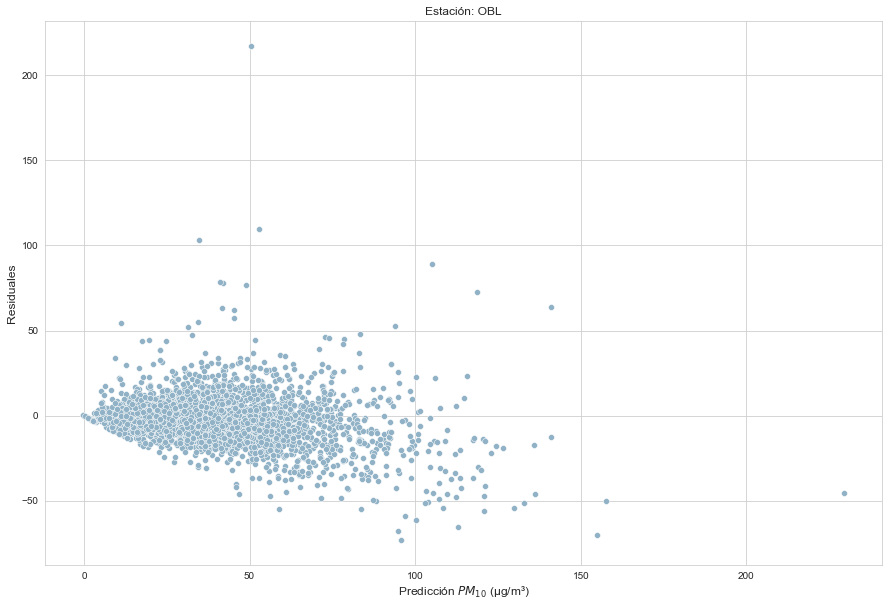


*For model model187 settings are: -epochs: 100 -hidden neurons: 75 -hidden layers: 5 -activation: relu -regularization cost: 0.1 -traintest: 96 -randomWeightInit 72 -station: OBL 
Accuracy for training is: 0.7319286806088681 Accuracy for test is: 0.6423038082086294 
MSE for training is: 116.71969837120646 MSE for test is: 162.0312840009034 
MAE for training is: 7.501963635450727 MAE for test is: 8.438577818632854 
RMSE for training is: 10.803689109336979 RMSE for test is: 12.72915095365372 
IA for training is: 0.928 IA for test is: 0.9


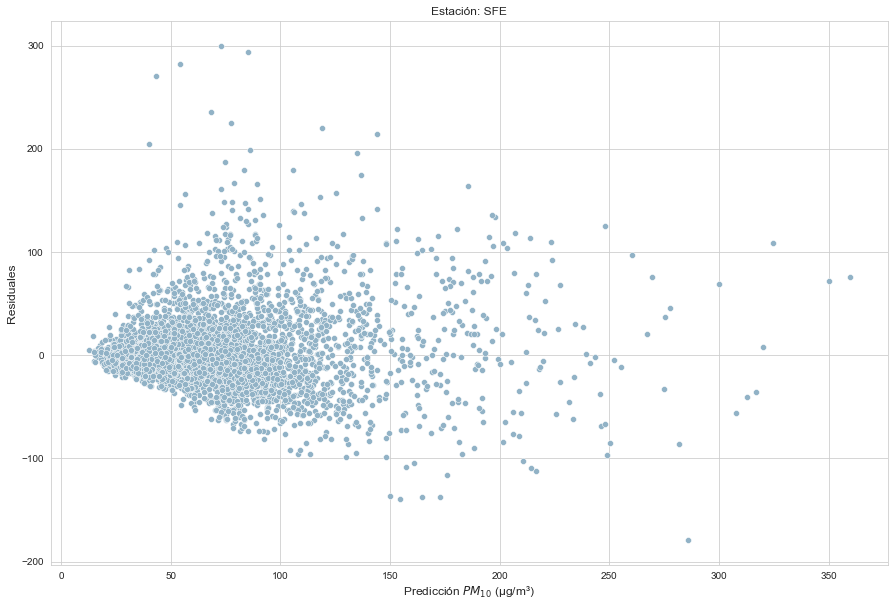


*For model model187 settings are: -epochs: 100 -hidden neurons: 75 -hidden layers: 5 -activation: relu -regularization cost: 0.1 -traintest: 96 -randomWeightInit 72 -station: SFE 
Accuracy for training is: 0.6029435944608299 Accuracy for test is: 0.5543147645085869 
MSE for training is: 1206.7218472868474 MSE for test is: 1308.944343238086 
MAE for training is: 22.94929549922199 MAE for test is: 23.970104714592708 
RMSE for training is: 34.73790217164599 RMSE for test is: 36.179335859549525 
IA for training is: 0.857 IA for test is: 0.835


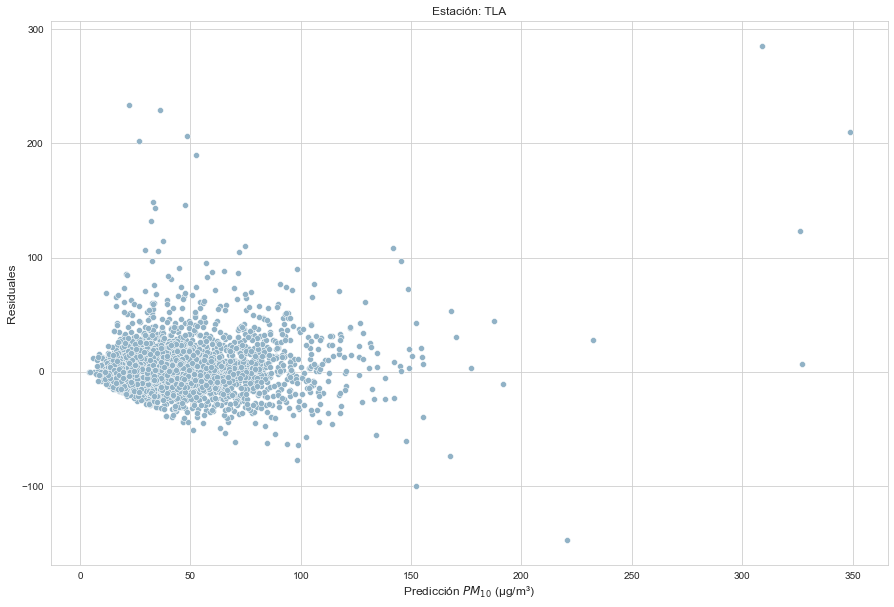


*For model model187 settings are: -epochs: 100 -hidden neurons: 75 -hidden layers: 5 -activation: relu -regularization cost: 0.1 -traintest: 96 -randomWeightInit 72 -station: TLA 
Accuracy for training is: 0.6875563172728145 Accuracy for test is: 0.659979982815293 
MSE for training is: 299.96815707479954 MSE for test is: 363.25589895304313 
MAE for training is: 10.62744977714407 MAE for test is: 11.140356569675996 
RMSE for training is: 17.319588825223292 RMSE for test is: 19.05927330600627 
IA for training is: 0.897 IA for test is: 0.881


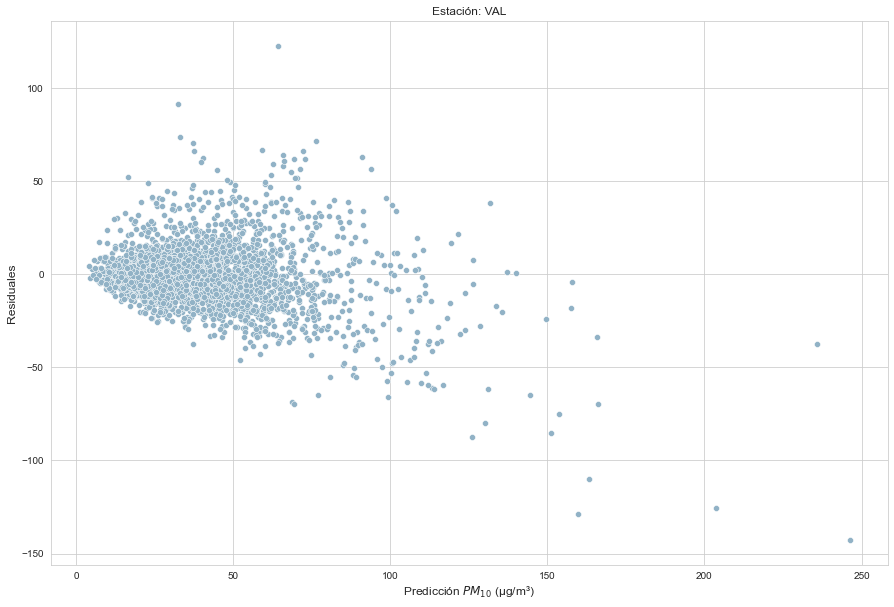


*For model model187 settings are: -epochs: 100 -hidden neurons: 75 -hidden layers: 5 -activation: relu -regularization cost: 0.1 -traintest: 96 -randomWeightInit 72 -station: VAL 
Accuracy for training is: 0.7029063575835255 Accuracy for test is: 0.557220841691354 
MSE for training is: 181.9236025533622 MSE for test is: 251.10002594146238 
MAE for training is: 9.153736623835437 MAE for test is: 10.543884504318237 
RMSE for training is: 13.487905788274256 RMSE for test is: 15.84613599403534 
IA for training is: 0.912 IA for test is: 0.868


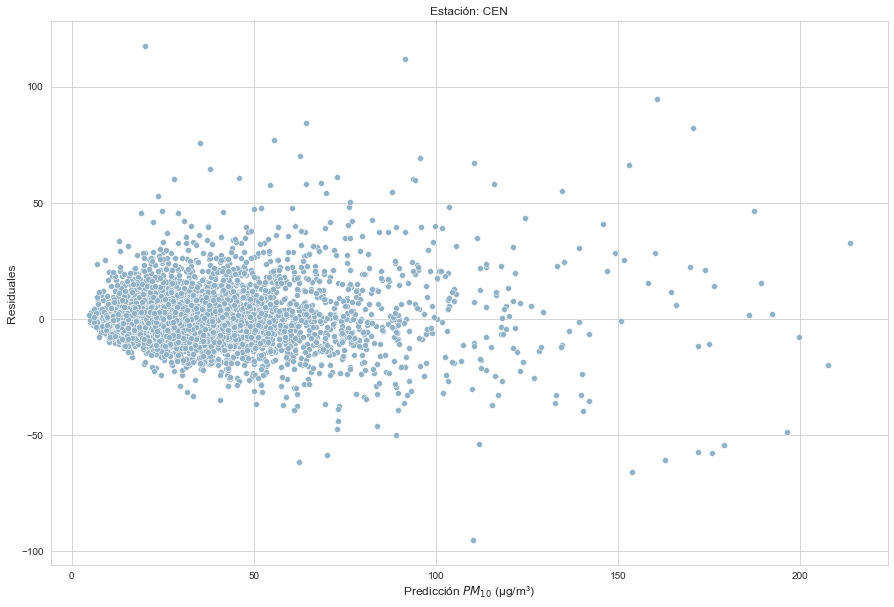


*For model model187 settings are: -epochs: 100 -hidden neurons: 75 -hidden layers: 5 -activation: relu -regularization cost: 0.1 -traintest: 96 -randomWeightInit 72 -station: CEN 
Accuracy for training is: 0.8284670960886462 Accuracy for test is: 0.7997600627099264 
MSE for training is: 112.31047553603062 MSE for test is: 136.67378061968017 
MAE for training is: 7.075656303993319 MAE for test is: 7.6740602938033655 
RMSE for training is: 10.597663682908165 RMSE for test is: 11.690756203927963 
IA for training is: 0.951 IA for test is: 0.941


In [33]:
prev_models = ['model9', 'model130', 'model187']
est = ['AGU','ATM','LDO','LPIN','MIR','OBL','SFE','TLA','VAL', 'CEN']

models = {}

for mn in prev_models:
    
    nh = int(nn.loc[nn['6d_number']==mn,'hidden_neurons'])
    hl = int(nn.loc[nn['6d_number']==mn,'hidden_layers'])
    e = int(nn.loc[nn['6d_number']==mn,'epochs'])
    a = 'relu'
    r = float(nn.loc[nn['6d_number']==mn,'regularization'])
    rnd_st = int(nn.loc[nn['6d_number']==mn,'random_state_trainsplit'])
    rnd_init = int(nn.loc[nn['6d_number']==mn,'random_WeightInit'])



    for e_y in est:

        est_tmp = est.copy()
        est_tmp.remove(e_y)

        dir_gdl = '../data/processed/2016-2019_3std_preprocessed.csv'
        df = pd.read_csv(dir_gdl)
        df_data = df[df['PARAM']=='PM10'].fillna(-1)
        df_data.drop(columns=['Unnamed: 0'], inplace=True)
        df_data = df_data[df_data[e_y] != -1] 

        X,Y = df_data[est_tmp].to_numpy(), df_data[e_y].to_numpy()   #separate data into input and output features

        Y=np.reshape(Y, (-1,1))

        X_std = (X - np.nanmin(np.where(X>=0, X, np.nan),axis=0)) / (X.max(axis=0) - np.nanmin(np.where(X>=0, X, np.nan),axis=0))
        xscale = X_std * (1 - 0) + 0
        xscale[X==-1]=-1

        scaler_y = MinMaxScaler()
        scaler_y.fit(Y)
        yscale=scaler_y.transform(Y)

        X_train,X_test,Y_train,Y_test = train_test_split(X, Y, 
                                                         test_size = 0.2,
                                                        random_state=rnd_st) #split


        model = neuron_layers(10,nh,1,hl,a,r, seed=rnd_init)

        model.compile(loss='mse', optimizer='adam', metrics=['mse','mae'])

        history = model.fit(X_train, Y_train, epochs=e, 
                            batch_size=50,  verbose=0, validation_split=0.2)

        #statistics for train
        y_hat= model.predict(X_train)
        acc_train = r2_score(Y_train, y_hat)
        mse_train = mean_squared_error(Y_train, y_hat)
        mae_train = mean_absolute_error(Y_train, y_hat)
        rmse_train = mean_squared_error(Y_train, y_hat, squared=False)

        num_train = ((y_hat - Y_train)**2).sum()
        den_train = ((abs(y_hat - Y_train.mean()) + 
                abs(Y_train - Y_train.mean()))**2).sum()
        ia_train = round(1 - (num_train / den_train),3)

        #accuracy for test
        y_hat = model.predict(X_test)
        acc_test = r2_score(Y_test, y_hat)
        mse_test = mean_squared_error(Y_test, y_hat)
        mae_test = mean_absolute_error(Y_test, y_hat)
        rmse_test = mean_squared_error(Y_test, y_hat, squared=False)

        num_test = ((y_hat - Y_test)**2).sum()
        den_test = ((abs(y_hat - Y_test.mean()) + 
                abs(Y_test - Y_test.mean()))**2).sum()
        ia_test = round(1 - (num_test / den_test),3)

        models[mn+'-'+e_y] = [e_y, e, nh, hl, a, r, rnd_st, rnd_init,
                                               acc_train, mse_train, mae_train, rmse_train, ia_train,
                                               acc_test, mse_test, mae_test, rmse_test, ia_test]
        
        y_hat = model.predict(X_test)
        residuals = Y_test - y_hat
        
        df_output = pd.DataFrame(X_test, columns=est_tmp)
        df_output[e_y+'_med'] = Y_test
        df_output[e_y+'_pred'] = y_hat
        df_output.to_csv(f'../output/data/RNA/Stations_Models/{e_y}_{mn}.csv')

        fig, ax = plt.subplots(figsize=(15,10))
        ax.scatter(y_hat, residuals, color='#91b2c6', linewidth=0.5, edgecolor='white')
        plt.xlabel('Predicción $PM_{10}$ (μg/m³)', fontsize=12)
        plt.ylabel('Residuales', fontsize=12)
        plt.title(f'Estación: {e_y}', fontsize=12)

        plt.savefig(f'../output/figures/RNN/Models/Residuals_{e_y}_{mn}.png',bbox_inches='tight', dpi=150)

        plt.show()

        print ('\n*For model',mn,'settings are:','-epochs:',str(e),'-hidden neurons:',str(nh),'-hidden layers:',str(hl),'-activation:',a,
               '-regularization cost:',r,'-traintest:',rnd_st,'-randomWeightInit',rnd_init,'-station:',e_y,
               '\nAccuracy for training is:', str(acc_train),'Accuracy for test is:',str(acc_test),
              '\nMSE for training is:', str(mse_train),'MSE for test is:',str(mse_test),
               '\nMAE for training is:', str(mae_train),'MAE for test is:',str(mae_test),
               '\nRMSE for training is:', str(rmse_train),'RMSE for test is:',str(rmse_test),
              '\nIA for training is:', str(ia_train),'IA for test is:',str(ia_test))